# Regression

In [1]:
include("utils.jl"); using .Utils
checkpkgs("DataFrames", "CSV", "StatsPlots", "GLM", "LaTeXStrings", "BenchmarkTools", "Statistics", "Distributions", "Dates")
checkpkgs("DataFramesMeta", "StatsBase", "Interpolations")

## More Snow?

In [2]:
getfile("https://github.com/AllenDowney/ThinkBayes2/raw/master/data/2239075.csv")

In [3]:
using DataFrames, CSV
df = DataFrame(CSV.File("2239075.csv"));

In [4]:
last(df, 3)

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX
,String,String,Date…,Float64,Float64?,Float64?,Int64
1,USC00190736,"BLUE HILL COOP, MA US",2020-05-09,0.45,0.0,0.0,57
2,USC00190736,"BLUE HILL COOP, MA US",2020-05-10,0.0,0.0,0.0,44
3,USC00190736,"BLUE HILL COOP, MA US",2020-05-11,0.0,0.0,0.0,59


In [5]:
using Dates
df.YEAR = year.(df.DATE);

In [6]:
snow = combine(groupby(select(df, [:YEAR, :SNOW]), :YEAR), :SNOW => sum => :SNOW);

In [7]:
snow = filter(r -> rownumber(r) ∉ [1, nrow(snow)], snow);
nrow(snow)

52

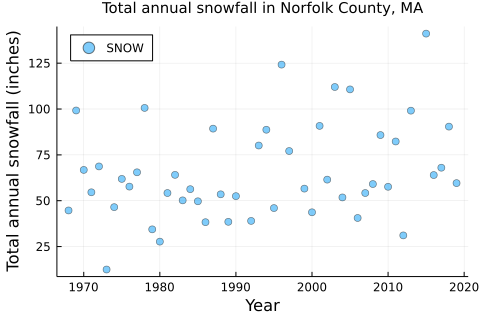

In [8]:
using StatsPlots
@df snow scatter(:YEAR, :SNOW, markertype=:circlt, alpha=0.5,
         legend=:topleft, label="SNOW", xlabel="Year",
         ylabel="Total annual snowfall (inches)",
         title="Total annual snowfall in Norfolk County, MA",
         titlefontsize=10)

In [9]:
filter(r -> r.YEAR ∈ [1978, 1996, 2015], snow)

,YEAR,SNOW
,Int64,Float64?
1,1978,100.6
2,1996,124.2
3,2015,141.1


## Regression Model

In [10]:
include("empiricaldist.jl"); using .EmpiricalDist

# snow contains several missing values, e.g. in 1991. This messes up Pmf.
# We can create a vector containing only non-missing values:
vec_snow = collect(skipmissing(snow.SNOW))

pmf_snowfall = pmffromseq(vec_snow);

In [11]:
using Statistics
μ, σ = mean(pmf_snowfall), std(pmf_snowfall)

(65.35714285714285, 25.900240326676347)

In [12]:
using Distributions
dist = Normal(μ, σ)
qs = pmf_snowfall.qs
ps = cdf.(dist, qs);

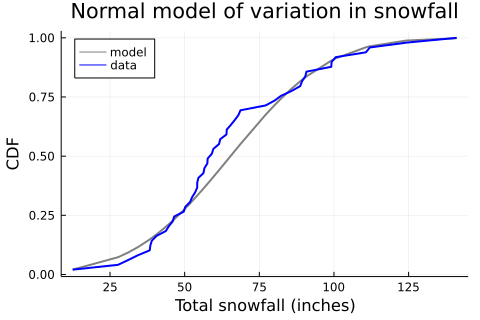

In [13]:
plot(qs, ps, color=:gray, label="model")
plot!(makecdf(pmf_snowfall), label="data",
     xlabel="Total snowfall (inches)",
         ylabel="CDF", legend=:topleft, color=:blue,
         title="Normal model of variation in snowfall")

## Least Squares Regression

In [14]:
# DataFrames doesn't have Series or indexes...
data = snow
first(data,3)

,YEAR,SNOW
,Int64,Float64?
1,1968,44.7
2,1969,99.2
3,1970,66.8


In [15]:
offset = data.YEAR |> mean |> round
data.x = data.YEAR .- offset
offset

1994.0

In [16]:
data.y = data.SNOW;

In [17]:
using GLM

ols = lm(@formula(y ~ x), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  65.8499      3.61041   18.24    <1e-22  58.5867     73.1131
x             0.513702    0.237737   2.16    0.0358   0.0354375   0.991966
──────────────────────────────────────────────────────────────────────────

In [18]:
sqrt(deviance(ols)/dof_residual(ols))

25.222406744752433

## Priors

In [19]:
qs = LinRange(-0.5, 1.5, 51)
prior_slope = makeuniform(qs, name="Slope");

In [20]:
qs = LinRange(54, 75, 41)
prior_inter = makeuniform(qs, name="Intercept");

In [21]:
qs = LinRange(20, 35, 31)
prior_sigma = makeuniform(qs, name="Sigma");

In [22]:
"""Make a joint distribution with three parameters."""
function make_joint3(pmf1, pmf2, pmf3)
    joint2 = stack(makejoint(pmf2, pmf1))
    joint3 = stack(makejoint(pmf3, joint2))
    return Pmf(joint3)
end

make_joint3

In [23]:
prior = make_joint3(prior_slope, prior_inter, prior_sigma)
first(prior, 3)

┌────────────────────┬────────────┐
│                    │      probs │
├────────────────────┼────────────┤
│ (-0.5, 54.0, 20.0) │ 1.54271e-5 │
│ (-0.5, 54.0, 20.5) │ 1.54271e-5 │
│ (-0.5, 54.0, 21.0) │ 1.54271e-5 │
└────────────────────┴────────────┘


In [24]:
length(prior_slope), length(prior_inter), length(prior_sigma)

(51, 41, 31)

In [25]:
length(prior_slope) * length(prior_inter) * length(prior_sigma)

64821

In [26]:
length(prior)

64821

## Likelihood

In [27]:
inter = 64
slope = 0.51
sigma = 25

25

In [28]:
# we need to get rid of missing values before we do calculations
data_wo_missing = dropmissing(data)

xs = data_wo_missing.x
ys = data_wo_missing.y;

In [29]:
expected = slope .* xs .+ inter
resid = ys .- expected;

In [30]:
densities = pdf.(Normal(0, sigma),resid);

In [31]:
likelihood = prod(densities)
likelihood

3.155929236507201e-99

## The Update

In [32]:
likelihood = copy(prior)

for (slope, inter, sigma) in keys(prior)
    expected = slope .* xs .+ inter
    resid = ys .- expected
    densities = pdf.(Normal(0, sigma), resid)
    likelihood[(slope, inter, sigma)] = prod(densities)
end

In [33]:
posterior = prior .* likelihood
normalize!(posterior)

1.8458118340485978e-100

In [34]:
posterior_slope = marginal(posterior, 1)
posterior_inter = marginal(posterior, 2)
posterior_sigma = marginal(posterior, 3);

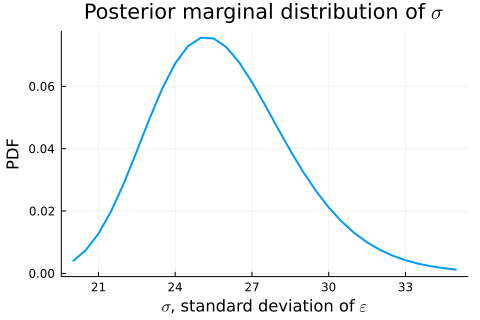

In [35]:
using LaTeXStrings
plot(posterior_sigma,
         xlabel=L"$\sigma$, standard deviation of $\epsilon$",
         ylabel="PDF",
         title=L"Posterior marginal distribution of $\sigma$")

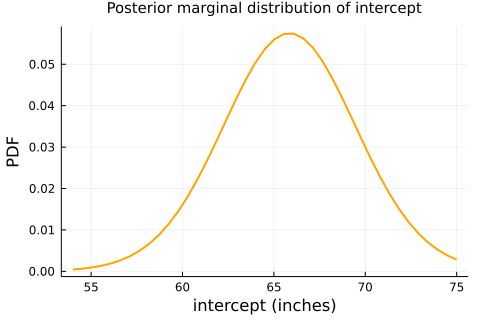

In [36]:
plot(posterior_inter, color=:orange, xlabel="intercept (inches)",
         ylabel="PDF", title="Posterior marginal distribution of intercept",
         titlefontsize=10)

In [37]:
summarize(posterior_inter)

65.791, [59.775, 71.85]


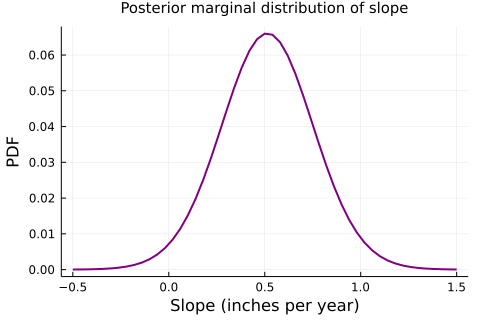

In [38]:
plot(posterior_slope, color=:purple, xlabel="Slope (inches per year)",
         ylabel="PDF", title="Posterior marginal distribution of slope",
         titlefontsize=10)

In [39]:
summarize(posterior_slope)

0.513, [0.09999999999999998, 0.8999999999999998]


In [40]:
makecdf(posterior_slope)(0)

0.022880078052894513

## Optimization

In [41]:
# this version is much faster than the previous one, but for a different reason
# than the Python implementation: in the first version, there's a slow search for
# each index. Here, instead, we iterate over rows of the JointDistribution

In [42]:
joint3 = unstack(prior)
first(joint3, 3)

┌────────────────┬────────────┬────────────┬────────────┬────────────┬──────────
│                │       20.0 │       20.5 │       21.0 │       21.5 │       2 ⋯
├────────────────┼────────────┼────────────┼────────────┼────────────┼──────────
│   (-0.5, 54.0) │ 1.54271e-5 │ 1.54271e-5 │ 1.54271e-5 │ 1.54271e-5 │ 1.54271 ⋯
│ (-0.5, 54.525) │ 1.54271e-5 │ 1.54271e-5 │ 1.54271e-5 │ 1.54271e-5 │ 1.54271 ⋯
│  (-0.5, 55.05) │ 1.54271e-5 │ 1.54271e-5 │ 1.54271e-5 │ 1.54271e-5 │ 1.54271 ⋯
└────────────────┴────────────┴────────────┴────────────┴────────────┴──────────
                                                              27 columns omitted


In [43]:
"""Posterior distribution of regression parameters
`slope`, `inter`, and `sigma`.

prior: Pmf representing the joint prior
data: DataFrame with columns `x` and `y`

returns: Pmf representing the joint posterior
"""
function update_optimized(prior, data)
    xs = data.x
    ys = data.y
    sigmas = columns(prior)
    likelihood = similar(prior)
    m = distribution(likelihood) # XXX

    for (row,(slope, inter)) in enumerate(rows(prior))
        expected = slope .* xs .+ inter
        resid = ys .- expected
        densities = pdf.(Normal.(0, sigmas'), resid)
        m[row, :] .= vec(prod(densities, dims=1))
    end
    posterior = prior .* likelihood
    normalize!(posterior)
    return posterior
end

update_optimized

In [44]:
length(prior_slope) * length(prior_inter)

2091

In [45]:
using BenchmarkTools
posterior_opt = update_optimized(joint3, data_wo_missing);
@btime update_optimized(joint3, data_wo_missing);

  50.395 ms (43916 allocations: 29.26 MiB)


In [46]:
isapprox(posterior, stack(posterior_opt))

true

In [47]:
posterior2 = marginal(posterior_opt, 2)
first(posterior2, 3)

┌────────────────┬────────────┐
│                │      probs │
├────────────────┼────────────┤
│   (-0.5, 54.0) │ 5.54123e-8 │
│ (-0.5, 54.525) │ 7.42794e-8 │
│  (-0.5, 55.05) │ 9.83584e-8 │
└────────────────┴────────────┘


In [48]:
joint_posterior = posterior2 |> unstack |> transpose
first(joint_posterior, 3)

┌────────┬────────────┬────────────┬────────────┬────────────┬────────────┬─────
│        │       -0.5 │      -0.46 │      -0.42 │      -0.38 │      -0.34 │    ⋯
├────────┼────────────┼────────────┼────────────┼────────────┼────────────┼─────
│   54.0 │ 5.54123e-8 │ 8.77053e-8 │ 1.36919e-7 │ 2.10737e-7 │ 3.19643e-7 │ 4. ⋯
│ 54.525 │ 7.42794e-8 │ 1.18146e-7 │ 1.85368e-7 │ 2.86765e-7 │ 4.37212e-7 │ 6. ⋯
│  55.05 │ 9.83584e-8 │ 1.57211e-7 │ 2.47893e-7 │ 3.85444e-7 │ 5.90693e-7 │ 8. ⋯
└────────┴────────────┴────────────┴────────────┴────────────┴────────────┴─────
                                                              46 columns omitted


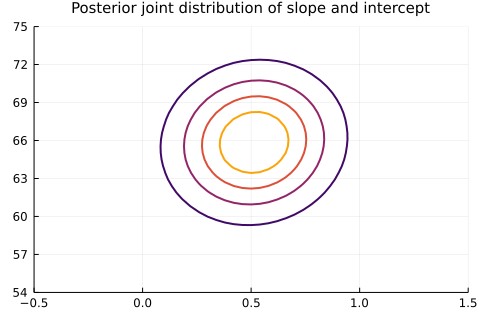

In [49]:
contour(joint_posterior, title="Posterior joint distribution of slope and intercept",
        titlefontsize=10)

## Marathon World Record

In [50]:
tables = retrievetables("https://github.com/AllenDowney/ThinkBayes2/raw/master/data/Marathon_world_record_progression.html")
length(tables)

┌ Warning: thread = 1 warning: parsed expected 1 columns, but didn't reach end of line around data row: 2. Ignoring any extra columns on this row
└ @ CSV /Users/sunny/.julia/packages/CSV/Zl2ww/src/file.jl:613
┌ Warning: thread = 1 warning: parsed expected 1 columns, but didn't reach end of line around data row: 27. Ignoring any extra columns on this row
└ @ CSV /Users/sunny/.julia/packages/CSV/Zl2ww/src/file.jl:613
┌ Warning: thread = 1 warning: only found 1 / 2 columns around data row: 2. Filling remaining columns with `missing`
└ @ CSV /Users/sunny/.julia/packages/CSV/Zl2ww/src/file.jl:612
┌ Warning: thread = 1 warning: only found 1 / 2 columns around data row: 3. Filling remaining columns with `missing`
└ @ CSV /Users/sunny/.julia/packages/CSV/Zl2ww/src/file.jl:612
┌ Warning: thread = 1 warning: only found 1 / 2 columns around data row: 4. Filling remaining columns with `missing`
└ @ CSV /Users/sunny/.julia/packages/CSV/Zl2ww/src/file.jl:612
┌ Warning: thread = 1 warning: only found

5

In [51]:
table = copy(tables[1])
first(table, 3)

,Time,Name,Nationality,Date,Event/Place
,Time,String,String,String,String
1,02:55:18.4,Johnny Hayes,United States,"July 24, 1908","London, United Kingdom"
2,02:52:45.4,Robert Fowler,United States,"January 1, 1909","Yonkers,[nb 5]United States"
3,02:46:52.8,James Clark,United States,"February 12, 1909","New York City, United States"


In [52]:
import Dates
df = DateFormat("U d, y")

# helper. returns `missing` instead of `nothing`
parsedate(d) = (p = tryparse(Date, d, df); isnothing(p) ? missing : p)

table.date = [parsedate(d) for d in table.Date];

In [53]:
# table.Time was already parsed as `Time`.
# this will give us the number of seconds (there must be a better way...)
seconds = Dates.value.(round.(table.Time-Time(0), Second))

# from which we can compute speeds in mph
table.y = 26.2 ./ seconds .* 3600
first(table.y, 5)

5-element Vector{Float64}:
 8.967484312606958
 9.09985528219971
 9.419754319384799
 9.46512794781736
 9.672854066249615

In [54]:
"""Plot marathon world record speed as a function of time.

df: DataFrame with date and mph
"""
function plot_speeds(df)
    d = select(df, Cols("date", "y")) |> dropmissing
    scatter(d.date, d.y, markertype=:circle, label="World record speed", 
             color=:orange, alpha=0.5,
             xlabel="Date",
             ylabel="Speed (mph)", legend=:bottomright)
    hline!([13.1], color=:gray, ls=:dash, label="")
end


plot_speeds

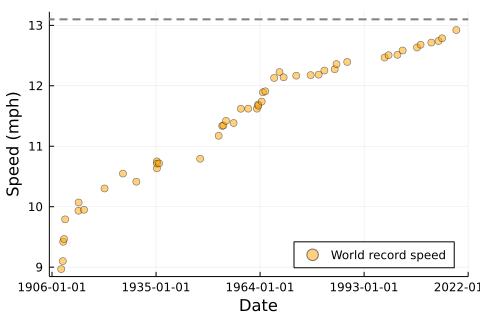

In [55]:
plot_speeds(table)

In [56]:
using DataFramesMeta

data = @chain table begin
            @select :date :y
            dropmissing
            @subset :date .>= Date(1970)
end;

first(data, 5)

,date,y
,Date,Float64
1,1970-07-23,12.1406
2,1974-01-31,12.1672
3,1978-02-05,12.1766
4,1980-04-26,12.1845
5,1981-12-06,12.2525


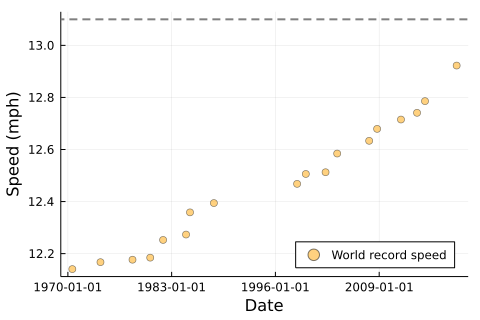

In [57]:
plot_speeds(data)

In [58]:
offset = Date(1995)

# substract offset and convert to years (from days)
data.x = Dates.value.(data.date - Date(1995)) / 365.24;

In [59]:
describe(data.x)

Summary Stats:
Length:         18
Missing Count:  0
Mean:           0.740913
Minimum:        -24.444201
1st Quartile:   -12.352152
Median:         4.264319
3rd Quartile:   13.492498
Maximum:        23.707699
Type:           Float64


In [60]:
ols = lm(@formula(y ~ x), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
──────────────────────────────────────────────────────────────────────────────
                  Coef.   Std. Error        t  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  12.4605     0.0100691    1237.49    <1e-40  12.4391     12.4818
x             0.0154691  0.000671191    23.05    <1e-12   0.0140462   0.016892
──────────────────────────────────────────────────────────────────────────────

In [61]:
sqrt(deviance(ols)/dof_residual(ols))

0.042667412857736446

## The Priors

In [62]:
qs = LinRange(0.012, 0.018, 51)
prior_slope = makeuniform(qs, name="Slope");

In [63]:
qs = LinRange(12.4, 12.5, 41)
prior_inter = makeuniform(qs, name="Intercept");

In [64]:
qs = LinRange(0.01, 0.21, 31)
prior_sigma = makeuniform(qs, name="Sigma");

In [65]:
prior = make_joint3(prior_slope, prior_inter, prior_sigma)
first(prior, 3)

┌──────────────────────────┬────────────┐
│                          │      probs │
├──────────────────────────┼────────────┤
│      (0.012, 12.4, 0.01) │ 1.54271e-5 │
│ (0.012, 12.4, 0.0166667) │ 1.54271e-5 │
│ (0.012, 12.4, 0.0233333) │ 1.54271e-5 │
└──────────────────────────┴────────────┘


In [66]:
xs = data.x
ys = data.y
likelihood = copy(prior)

for (slope, inter, sigma) in keys(prior)
    expected = slope .* xs .+ inter
    resid = ys .- expected
    densities = pdf.(Normal(0, sigma), resid)
    likelihood[(slope, inter, sigma)] = prod(densities)
end

In [67]:
posterior = prior .* likelihood
normalize!(posterior)

6.555554764826748e11

In [68]:
posterior_slope = marginal(posterior, 1)
posterior_inter = marginal(posterior, 2)
posterior_sigma = marginal(posterior, 3);

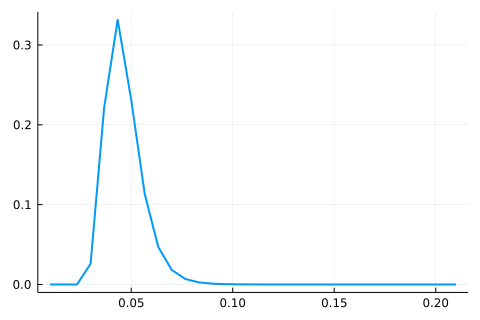

In [69]:
plot(posterior_sigma)

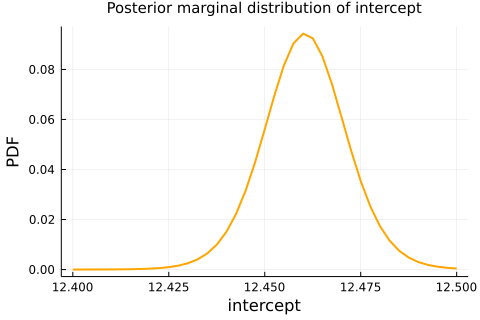

In [70]:
plot(posterior_inter, color=:orange, xlabel="intercept",
         ylabel="PDF", title="Posterior marginal distribution of intercept",
         titlefontsize=10)

In [71]:
summarize(posterior_inter)

12.46, [12.442499999999999, 12.4775]


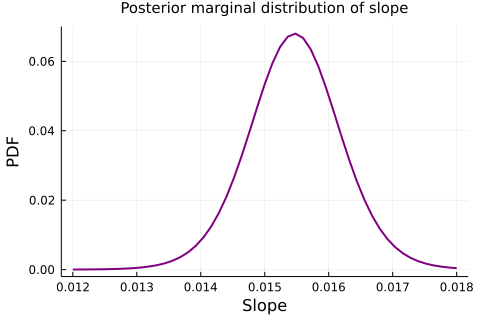

In [72]:
plot(posterior_slope, color=:purple, xlabel="Slope", ylabel="PDF",
         title="Posterior marginal distribution of slope",
         titlefontsize=10)

In [73]:
summarize(posterior_slope)

0.015, [0.014280000000000001, 0.016679999999999997]


## Prediction

In [74]:
import Random
Random.seed!(17)

MersenneTwister(17)

In [75]:
samp = rand(posterior, 101);

In [76]:
xs = range(-25, 50, step=2)
pred = Matrix(undef, length(samp), length(xs))

for (i, (slope, inter, sigma)) in enumerate(samp)
    epsilon = rand(Normal(0, sigma), length(xs))
    pred[i, :] = inter .+ slope .* xs .+ epsilon
end

In [77]:
using StatsBase
low, med, hi = (percentile.(eachcol(pred), p) for p in [5, 50, 95]);

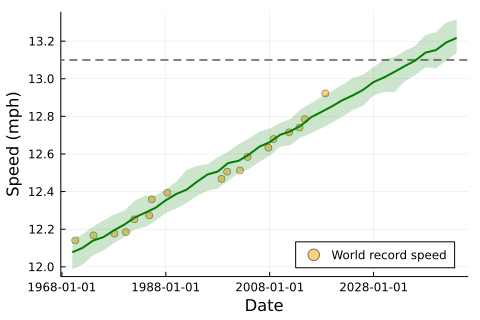

In [78]:
times = offset .+ Dates.Day.(round.(xs*365.24))

plot_speeds(data)
plot!(times, med, color=:green, label="", legend=:bottomright)
plot!(times, low, fillrange = hi, fillalpha = 0.2, lw=0, color = :green, label="")

In [79]:
using Interpolations

# LinearInterpolation expects `x` values to be sorted, so, this helper function
interp(x, y) = (p = sortperm(x); LinearInterpolation(x[p], y[p]))

future = [interp(hi, xs)(13.1),
                   interp(med, xs)(13.1),
                   interp(low, xs)(13.1)];

In [80]:
dts = Day.(round.(future*365.24)) + offset
DataFrame(:index=>["early", "median", "late"], :datetime=>dts)

,index,datetime
,String,Date
1,early,2029-11-22
2,median,2036-02-28
3,late,2042-02-26


## Summary

## Exercises

In [81]:
df = CSV.File("2239075.csv") |> DataFrame
first(df, 3)

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX
,String,String,Date,Float64,Float64?,Float64?,Int64
1,USC00190736,"BLUE HILL COOP, MA US",1967-05-11,0.43,0.0,0.0,57
2,USC00190736,"BLUE HILL COOP, MA US",1967-05-12,0.0,0.0,0.0,58
3,USC00190736,"BLUE HILL COOP, MA US",1967-05-13,0.0,0.0,0.0,64


In [82]:
df.YEAR = year.(df.DATE);

In [83]:
df.TMID = (df.TMIN .+ df.TMAX) ./ 2;

In [84]:
tmid = @chain df begin
    @select :YEAR :TMID
    @by :YEAR :TMID = mean(:TMID)
end
nrow(tmid)

54

In [85]:
complete = filter(r -> rownumber(r) ∉ [1, nrow(tmid)], tmid)
nrow(complete)

52

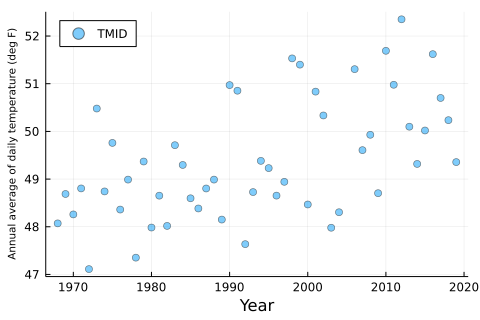

In [86]:
@df complete scatter(:YEAR, :TMID, markertype=:circle, alpha=0.5,
        xlabel="Year", ylabel="Annual average of daily temperature (deg F)",
        ylabelfontsize=7, label="TMID", legend=:topleft)

In [87]:
data = dropmissing(complete, disallowmissing=true)
first(data, 5)

,YEAR,TMID
,Int64,Float64
1,1968,48.071
2,1969,48.6877
3,1970,48.2589
4,1971,48.8041
5,1972,47.112


In [88]:
offset = round(mean(data.YEAR))

1993.0

In [89]:
data.x = data.YEAR .- offset
mean(data.x)

0.27450980392156865

In [90]:
data.y = data.TMID
std(data.y)

1.2511839344032232

In [91]:
ols = lm(@formula(y ~ x), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  49.3942     0.148587    332.43    <1e-83  49.0956     49.6928
x             0.0446844  0.00985995    4.53    <1e-04   0.0248701   0.0644987
─────────────────────────────────────────────────────────────────────────────

In [92]:
sqrt(deviance(ols)/dof_residual(ols))

1.0609488480870501

In [93]:
# Solution

qs = LinRange(0, 0.1, 51)
prior_slope = makeuniform(qs, name="Slope");

In [94]:
# Solution

qs = LinRange(48, 52, 41)
prior_inter = makeuniform(qs, name="Intercept");

In [95]:
# Solution

qs = LinRange(0.5, 2, 31)
prior_sigma = makeuniform(qs, name="Sigma");

In [96]:
# Solution

prior = make_joint3(prior_slope, prior_inter, prior_sigma)
first(prior, 5)

┌───────────────────┬────────────┐
│                   │      probs │
├───────────────────┼────────────┤
│  (0.0, 48.0, 0.5) │ 1.54271e-5 │
│ (0.0, 48.0, 0.55) │ 1.54271e-5 │
│  (0.0, 48.0, 0.6) │ 1.54271e-5 │
│ (0.0, 48.0, 0.65) │ 1.54271e-5 │
│  (0.0, 48.0, 0.7) │ 1.54271e-5 │
└───────────────────┴────────────┘


In [97]:
xs = data.x
ys = data.y

likelihood = copy(prior)

for (slope, inter, sigma) in keys(prior)
    expected = slope .* xs .+ inter
    resid = ys .- expected
    densities = pdf.(Normal(0, sigma), resid)
    likelihood[(slope, inter, sigma)] = prod(densities)
end

In [98]:
# Solution

posterior = prior .* likelihood
normalize!(posterior)

1.9293477849720073e-35

In [99]:
# Solution

posterior_slope = marginal(posterior, 1)
posterior_inter = marginal(posterior, 2)
posterior_sigma = marginal(posterior, 3);

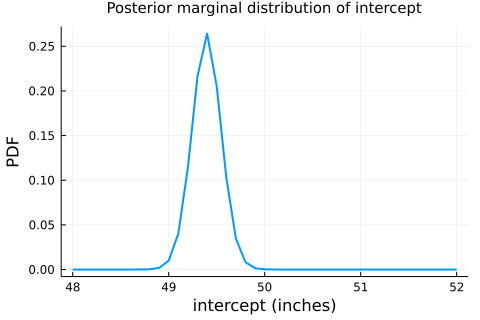

In [100]:
# Solution

plot(posterior_inter,
         xlabel="intercept (inches)",
         ylabel="PDF",
         title="Posterior marginal distribution of intercept",
         titlefontsize=10)

In [101]:
# Solution

mean(posterior_inter), credibleinterval(posterior_inter, 0.9)

(49.394165224738614, [49.099999999999994, 49.599999999999994])

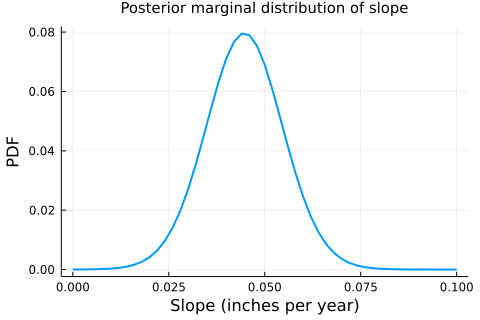

In [102]:
# Solution

plot(posterior_slope, xlabel="Slope (inches per year)",
         ylabel="PDF", title="Posterior marginal distribution of slope",
         titlefontsize=10)

In [103]:
# Solution

mean(posterior_slope), credibleinterval(posterior_slope, 0.9)

(0.04468515018939393, [0.028000000000000004, 0.062])

In [104]:
# Solution

samp = rand(posterior, 101)

years = 1967:2:2066
xs = years .- offset

pred = Matrix(undef, length(samp), length(xs))

for (i, (slope, inter, sigma)) in enumerate(samp)
    epsilon = rand(Normal(0, sigma), length(xs))
    pred[i, :] = inter .+ slope .* xs .+ epsilon
end

size(pred)

(101, 50)

In [105]:
low, med, hi = (percentile.(eachcol(pred), p) for p in [5, 50, 95])
size(med)

(50,)

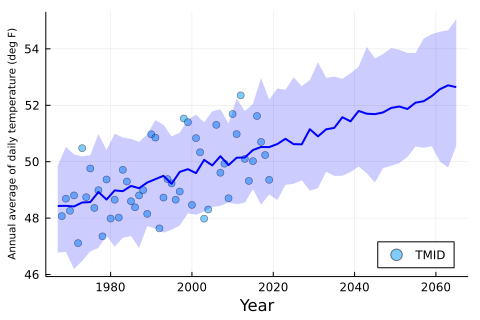

In [110]:
# Solution

@df complete scatter(:YEAR, :TMID, markertype=:circle, alpha=0.5,
        xlabel="Year", ylabel="Annual average of daily temperature (deg F)",
        ylabelfontsize=7, label="TMID", legend=:topleft)

plot!(years, med, color=:blue, label="", legend=:bottomright)
plot!(years, low, fillrange = hi, fillalpha = 0.2, lw=0, color = :blue, label="")


In [112]:
# Solution

# median increase over my lifetime in degrees F

med[end] - med[1]

4.213186008306877